<a href="https://colab.research.google.com/github/Zakir176/APRS/blob/main/txtToCsv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📤 Please upload your WhatsApp chat export (.txt)


Saving Abigail_chat.txt to Abigail_chat.txt
✅ Detected format: android_12hr


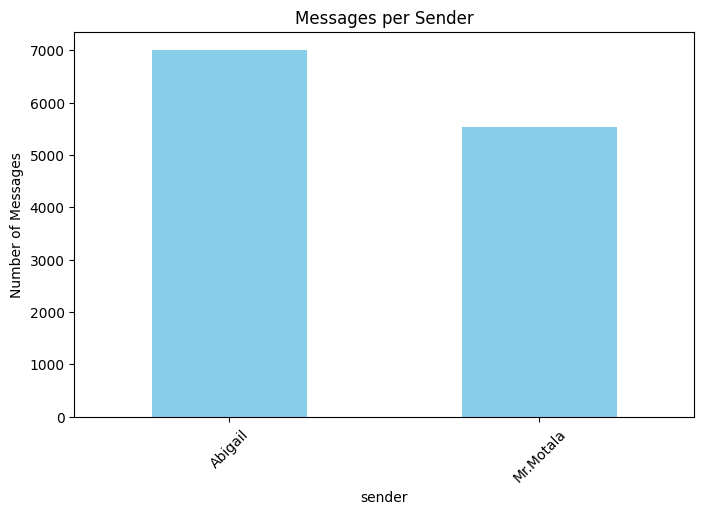

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📂 Saved 12539 messages with classifications to whatsapp_parsed_classified.csv


,date,time,sender,message,tone,urgency
1,21/04/2024,2:57:29 PM,Abigail,‎Abigail changed their phone number. You're cu...,neutral,none
2,30/04/2024,11:16:59 AM,Abigail,‎‎‎Disappearing messages were turned on. ‎New ...,casual,none
3,14/09/2024,10:38:07 PM,Abigail,‎You pinned a message,neutral,none
4,21/09/2024,6:54:50 PM,Mr.Motala,8fxs(HJUDc2-Hz.,neutral,none
5,08/10/2024,9:02:04 PM,Abigail,‎‎Abigail turned off disappearing messages. ‎T...,neutral,none


In [2]:
# Step 1: Install dependencies
!pip install pandas regex matplotlib

import pandas as pd
import re
import matplotlib.pyplot as plt
from google.colab import files

# Step 2: Upload chat export
print("📤 Please upload your WhatsApp chat export (.txt)")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# Step 3: Load file
with open(file_name, 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Step 4: Define regex patterns for multiple formats
patterns = {
    "android_12hr": r'^\[(\d{1,2}/\d{1,2}/\d{4}), (\d{1,2}:\d{2}(?::\d{2})? [AP]M)\] ([^:]+): (.+)',
    "android_24hr": r'^\[(\d{1,2}/\d{1,2}/\d{4}), (\d{1,2}:\d{2}(?::\d{2})?)\] ([^:]+): (.+)',
    "iphone": r'^(\d{1,2}/\d{1,2}/\d{2,4}), (\d{1,2}:\d{2} [AP]M) - ([^:]+): (.+)'
}

# Step 5: Detect pattern
detected_pattern = None
for name, pattern in patterns.items():
    for line in lines:
        if re.match(pattern, line):
            detected_pattern = pattern
            print(f"✅ Detected format: {name}")
            break
    if detected_pattern:
        break

if not detected_pattern:
    print("⚠ No pattern matched. Defaulting to Android 12hr")
    detected_pattern = patterns["android_12hr"]

# Step 6: Parse messages
data = []
message_buffer = None

for line in lines:
    match = re.match(detected_pattern, line)
    if match:
        if message_buffer:
            data.append(message_buffer)
        message_buffer = list(match.groups())
    else:
        if message_buffer:
            message_buffer[-1] += "\n" + line.strip()

if message_buffer:
    data.append(message_buffer)

# Step 7: Create DataFrame
if len(data) > 0:
    df = pd.DataFrame(data, columns=['date', 'time', 'sender', 'message'])

    # Remove system messages
    df = df[~df['message'].str.contains("end-to-end encrypted", case=False, na=False)]

    # Step 8: Classification Rules
    tone_rules = {
        'casual': ['lol', 'haha', '😊', 'hey', 'bro', '👍', 'lmao'],
        'formal': ['dear', 'regards', 'sincerely', 'please', 'thank you'],
        'apologetic': ['sorry', 'apologies', 'my bad', 'forgive me', 'oops'],
        'neutral': []
    }

    urgency_rules = {
        'high': ['urgent', 'asap', 'now!', 'emergency', 'important', 'quick'],
        'medium': ['when you can', 'soon', 'later', 'at your convenience'],
        'low': ['no rush', 'whenever', 'anytime', 'no hurry'],
        'none': []
    }

    def classify_tone(text):
        text = str(text).lower()
        for tone, keywords in tone_rules.items():
            if any(keyword in text for keyword in keywords):
                return tone
        return 'neutral'

    def classify_urgency(text):
        text = str(text).lower()
        for urgency, keywords in urgency_rules.items():
            if any(keyword in text for keyword in keywords):
                return urgency
        return 'none'

    df['tone'] = df['message'].apply(classify_tone)
    df['urgency'] = df['message'].apply(classify_urgency)

    # Step 9: Visualization
    msg_counts = df['sender'].value_counts()
    plt.figure(figsize=(8, 5))
    msg_counts.plot(kind='bar', color='skyblue')
    plt.title("Messages per Sender")
    plt.ylabel("Number of Messages")
    plt.xticks(rotation=45)
    plt.show()

    # Step 10: Save & download
    output_file = "whatsapp_parsed_classified.csv"
    df.to_csv(output_file, index=False, encoding='utf-8')
    files.download(output_file)

    print(f"📂 Saved {len(df)} messages with classifications to {output_file}")
else:
    print("❌ No messages could be parsed. Check if the export format is supported.")

# Preview
df.head()


In [ ]:
# ============================================
# AI WhatsApp Reply Generator (distilgpt2)
# Option B: Train on BOTH sides (role-aware)
# ============================================

!pip install -q transformers datasets accelerate

import pandas as pd
import numpy as np
import re, os, math
from google.colab import files
from datetime import datetime

import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    pipeline,
)

# ---------------------------
# 1) Upload your parsed CSV
#    Expected columns:
#    date, time, sender, message
#    (optionally tone, urgency)
# ---------------------------
print("📤 Upload your parsed CSV (e.g., whatsapp_parsed_classified.csv)")
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]

df = pd.read_csv(csv_path)

# Basic hygiene
for col in ["date", "time", "sender", "message"]:
    if col not in df.columns:
        raise ValueError(f"Missing column: {col} — please re-run your parser that outputs {['date','time','sender','message']}")

# Remove system lines if any slipped through
df = df[~df["message"].fillna("").str.contains("end-to-end encrypted", case=False)]
df = df.dropna(subset=["sender","message"])

# Build timestamp and sort chronologically (works for multiple formats; adjust dayfirst=True for WhatsApp)
def safe_parse_dt(d, t):
    s = f"{d} {t}"
    for fmt in ["%d/%m/%Y %I:%M:%S %p", "%d/%m/%Y %H:%M:%S", "%d/%m/%Y %I:%M %p", "%d/%m/%Y %H:%M",
                "%m/%d/%Y %I:%M:%S %p", "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M %p", "%m/%d/%Y %H:%M"]:
        try:
            return datetime.strptime(s, fmt)
        except:
            continue
    return pd.NaT

df["timestamp"] = [safe_parse_dt(d, t) for d,t in zip(df["date"], df["time"])]
if df["timestamp"].isna().all():
    # fallback: try pandas auto parse with dayfirst
    df["timestamp"] = pd.to_datetime(df["date"] + " " + df["time"], errors="coerce", dayfirst=True)

df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

# Optionally normalize whitespace but keep line breaks
def clean_text(x):
    x = str(x).replace("\r\n", "\n").replace("\r", "\n")
    x = re.sub(r"[ \t]+", " ", x)                # collapse spaces
    x = re.sub(r"\n{3,}", "\n\n", x)             # limit blank lines
    return x.strip()

df["message"] = df["message"].apply(clean_text)

# ---------------------------
# 2) Build Prompt→Reply pairs
#    We use consecutive turns where sender changes:
#    prompt = row i
#    reply  = row i+1
# ---------------------------
has_tone = "tone" in df.columns
has_urg  = "urgency" in df.columns

pairs = []
for i in range(len(df)-1):
    cur = df.iloc[i]
    nxt = df.iloc[i+1]
    if cur["sender"] != nxt["sender"]:  # only true conversation turns
        tone = cur["tone"] if has_tone and pd.notna(cur["tone"]) else "unknown"
        urg  = cur["urgency"] if has_urg and pd.notna(cur["urgency"]) else "unknown"

        # Role-aware format + light metadata (tone/urgency)
        prompt = (
            f"<turn>\n"
            f"[TIME:{cur['timestamp']}] [SENDER:{cur['sender']}]\n"
            f"[TONE:{tone}] [URGENCY:{urg}]\n"
            f"{cur['message']}\n"
            f"</turn>\n"
            f"<reply>\n"  # model should complete after this tag
        )
        reply = (
            f"[SENDER:{nxt['sender']}]\n"
            f"{nxt['message']}\n"
            f"</reply>\n"
        )

        # Skip extremely long samples (helps small GPUs)
        if len(prompt) + len(reply) < 2500:
            pairs.append({"text": prompt + reply})

print(f"✅ Built {len(pairs)} prompt→reply pairs.")

if len(pairs) < 100:
    print("⚠️ Heads-up: fewer than 100 pairs. You can still train, but consider adding more chats for better results.")

train_df = pd.DataFrame(pairs)
dataset = Dataset.from_pandas(train_df)

# ---------------------------
# 3) Tokenizer & Model
# ---------------------------
model_name = "distilgpt2"  # small + fast
tokenizer = AutoTokenizer.from_pretrained(model_name)
# GPT-2 family has no pad token by default
tokenizer.pad_token = tokenizer.eos_token

# Special tokens help structure turns (optional but useful)
special_tokens = {"additional_special_tokens": ["<turn>", "</turn>", "<reply>", "</reply>"]}
tokenizer.add_special_tokens(special_tokens)

model = AutoModelForCausalLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# ---------------------------
# 4) Tokenize dataset
# ---------------------------
max_len = 512  # keep small for Colab; increase if you have longer context
def tok_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=max_len)

tok_ds = dataset.map(tok_fn, batched=True, remove_columns=["text"])
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# ---------------------------
# 5) Training setup
# ---------------------------
out_dir = "aprs-distilgpt2-both-sides"
bsz = 2
args = TrainingArguments(
    output_dir=out_dir,
    per_device_train_batch_size=bsz,
    gradient_accumulation_steps=8,     # effective batch size 16
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_ratio=0.05,
    logging_steps=50,
    save_steps=500,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    bf16=False,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tok_ds,
    eval_dataset=None,
    data_collator=data_collator,
)

print("🚀 Starting training…")
trainer.train()
trainer.save_model(out_dir)
tokenizer.save_pretrained(out_dir)
print(f"✅ Model saved to {out_dir}")

# ---------------------------
# 6) Quick test generation
# ---------------------------
gen_pipe = pipeline("text-generation", model=out_dir, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

def generate_reply(incoming_text, incoming_sender="Friend", tone="unknown", urgency="unknown"):
    # Use the same structure the model saw during training
    prompt = (
        f"<turn>\n"
        f"[TIME:{datetime.now()}] [SENDER:{incoming_sender}]\n"
        f"[TONE:{tone}] [URGENCY:{urgency}]\n"
        f"{clean_text(incoming_text)}\n"
        f"</turn>\n"
        f"<reply>\n"
        f"[SENDER:You]\n"
    )
    out = gen_pipe(
        prompt,
        max_new_tokens=80,
        do_sample=True,
        top_p=0.92,
        temperature=0.8,
        repetition_penalty=1.1,
        eos_token_id=tokenizer.convert_tokens_to_ids("</reply>")
    )[0]["generated_text"]

    # Extract only the generated reply content up to </reply>
    gen = out.split("<reply>")[-1]
    gen = gen.split("</reply>")[0]
    return gen.strip()

# Demo
print("\n--- Demo ---")
demo_in = "Hey, are you free later to talk about the plan?"
print("User:", demo_in)
print("Bot:", generate_reply(demo_in, incoming_sender="Alex", tone="casual", urgency="low"))


📤 Upload your parsed CSV (e.g., whatsapp_parsed_classified.csv)


Saving whatsapp_parsed_classified.csv to whatsapp_parsed_classified (1).csv
✅ Built 7459 prompt→reply pairs.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Map:   0%|          | 0/7459 [00:00<?, ? examples/s]

🚀 Starting training…


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
